In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150
rcParams["text.usetex"] = True
import tqdm

In [2]:
import numpy as np
import scipy.special as sps
import scipy.stats as stats
import scipy.integrate as integrate

In [3]:
np.warnings.filterwarnings('ignore')

In [4]:
from maoud import AlphaMu

In [5]:
K = int(1e7) # Number of Monte Carlo realizations
N = 1        # Number of transmitted samples
alpha, mu = 2., 5.

In [6]:
alphamu = AlphaMu(alpha, mu)

In [7]:
x = np.linspace(1e-3, 5., 1000) # Support of the fading density
h = alphamu.rvs(x=x, size=K)

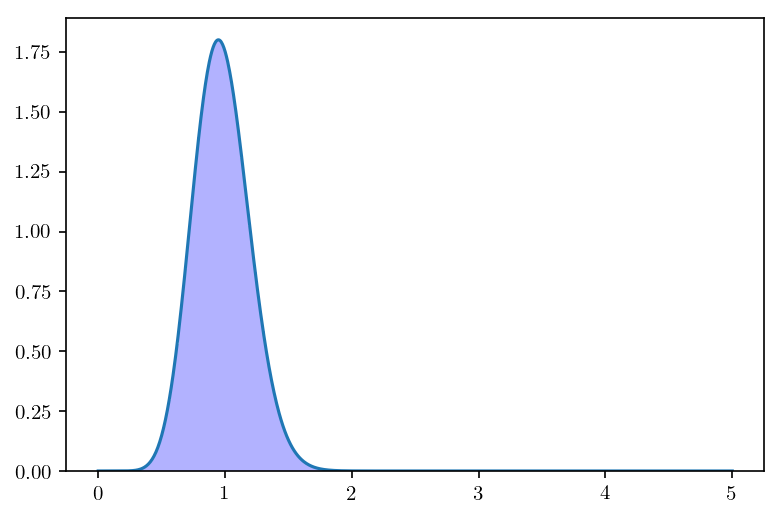

In [8]:
plt.plot(x, alphamu.pdf(x))
hist = plt.hist(h, bins=100, density=True, color='blue', alpha=.3)

## Simulation

In [9]:
snr_list = np.linspace(-20, 50, 15) # signal to noise ratio in dB
a = 1
pf = np.zeros(len(snr_list))
pm = np.zeros(len(snr_list))
pm_awgn = np.zeros(len(snr_list))
for l, snr_db in enumerate(snr_list):
    sigma2 = a * (10 ** (-snr_db / 10.))
    h = alphamu.rvs(x=x, size=K)
    w = np.sqrt(sigma2)*np.random.randn(K)
    y = h*a + w
    # computing probabilities of false alarm and miss detection
    pf[l] = np.sum(w > a / 2.)
    pm[l] = np.sum((y-a)**2 > y ** 2)
pf = pf / K
pm = pm / K
pe = .5*(pf + pm)

## Theorectical Analysis

In [10]:
snr_array = np.linspace(-20, 50, 1000)
sigma = np.sqrt(a * (10 ** (-snr_array / 10.)))
Pm = np.zeros(len(snr_array))
Pf = 1.0 - stats.norm.cdf(a / (2 * sigma))

In [11]:
for l in tqdm.tqdm(range(len(snr_array))):
    cdf = lambda x: stats.norm.cdf(a * (1 - 2 * x) / (2 * sigma[l]))*alphamu.pdf(x) 
    Pm[l] = integrate.quad(cdf, 0.0, np.inf, epsrel=1e-9, epsabs=0)[0]
Pe = .5 * (Pf + Pm)

100%|██████████| 1000/1000 [00:32<00:00, 30.47it/s]


## Plot

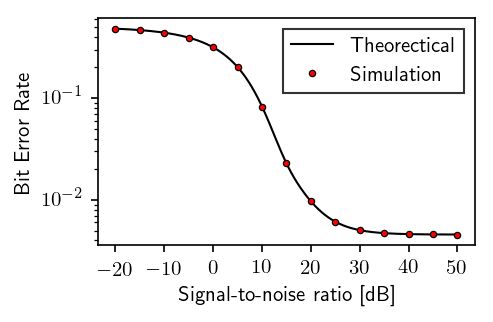

In [13]:
fig, ax = plt.subplots(figsize=(3.2360679775, 2))
ax.semilogy(snr_array, Pe, 'k-', linewidth=1, label=r"Theorectical")
ax.semilogy(snr_list, pe, 'o', color='red', markeredgecolor='k', mew=.6, markersize=3., label=r"Simulation")
plt.xticks([-20, -10, 0, 10, 20, 30, 40, 50])
plt.ylabel(r'Bit Error Rate')
plt.xlabel(r'Signal-to-noise ratio [dB]')
plt.legend(fancybox=False, numpoints=1, edgecolor='k')
plt.savefig('ber.ps', transparent=True, bbox_inches='tight', pad_inches=.1)